# Deep Learning approach to the Boston Housing dataset - Autoencoder
## Team JARL

In [1]:
#import libraries and load data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras

from keras import regularizers, layers
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

data = pd.read_csv('boston_corrected.csv')
data = data.sample(frac=1).reset_index(drop=True)

train = data.iloc[:450,:]
test = data.iloc[450:,:]

In [3]:
# Drop undesired columns
rem = ['MEDV', 'CMEDV','TOWN','TOWNNO','TRACT']

raw_X_train = train.drop(rem, axis=1)
raw_Y_train = train['CMEDV']
raw_X_test = test.drop(rem, axis=1)
raw_Y_test = test['CMEDV']

In [4]:
# Set all column types to numeric
raw_X_train = np.asarray(raw_X_train).astype(np.float32)
raw_X_test = np.asarray(raw_X_test).astype(np.float32)
raw_Y_train = np.asarray(raw_Y_train).astype(np.float32)
raw_Y_test = np.asarray(raw_Y_test).astype(np.float32)

def Z_scoreNorm(data):
    column_mean = data.mean(axis=0)
    column_std = np.std(data, axis=0, dtype=float)
    Normalized_Inputs = (data - column_mean)/column_std
    
    return Normalized_Inputs

X_train = Z_scoreNorm(raw_X_train)
X_test = Z_scoreNorm(raw_X_test)
Y_train = Z_scoreNorm(raw_Y_train)
Y_test = Z_scoreNorm(raw_Y_test)

In [5]:
# Reality check
print(X_train.shape)
print(X_test.shape)

(450, 15)
(56, 15)
(450, 16)


In [6]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=100,
    restore_best_weights=True,
)

In [7]:
choke = 10

autoencoder = Sequential([
    Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(choke, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(X_train.shape[1])
])

In [ ]:
autoencoder.compile(optimizer=Adam(lr=0.01), 
                    loss='MSE', 
                    metrics=['mean_squared_error'])
checkpointer_a = ModelCheckpoint(filepath="AE.z1",
                               verbose=0,
                               save_best_only=True)
history_a = autoencoder.fit(X_train, X_train,
                    epochs=700,
                    batch_size=450,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[early_stopping, checkpointer_a]).history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                3

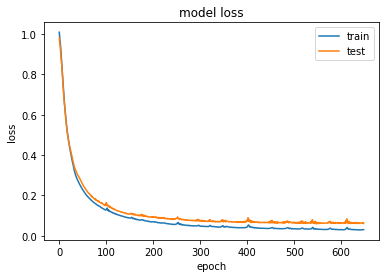

In [11]:
plt.plot(history_a['loss'])
plt.plot(history_a['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

autoencoder.summary()

In [12]:
# Reality check
a = 5
testinp = np.array(X_train[a,:]).reshape(1,X_train.shape[1])
y = autoencoder.predict(testinp)

print(np.array(X_train[a,:]))
print(y)

[ 1.25895578  2.69573478 -0.42702645  3.30362986 -1.42925767 -0.26726126
 -1.30707499  1.3087711  -1.63190455  2.30518275 -0.51942312 -1.08616831
 -0.22406789  0.4261515  -1.08065671]
[[ 1.1714578   2.6285663  -0.32403398  3.449032   -1.4068097  -0.22252215
  -1.279017    0.7656801  -1.2600056   2.0380476  -0.62356174 -0.76941955
  -0.37066987  0.7190219  -1.0265939 ]]


In [13]:
# Latent feature extraction
latent_model = Model(autoencoder.input, autoencoder.get_layer(index = 3).output )

latents_train = np.array([latent_model.predict(i.reshape(1, X_train.shape[1])) for i in X_train]).reshape(450, choke)
latents_test = np.array([latent_model.predict(i.reshape(1, X_train.shape[1])) for i in X_test]).reshape(56, choke)

In [56]:
valuePredictor = Sequential([
    Dense(choke, activation='relu', input_shape=(choke,)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [ ]:
valuePredictor.compile(optimizer=Adam(lr=0.01), 
                    loss='MSE', 
                    metrics=['mean_squared_error'])
checkpointer_m = ModelCheckpoint(filepath="valuePredictor.z1",
                              verbose=0,
                              save_best_only=True)
history_m = valuePredictor.fit(latents_train, Y_train,
                    epochs=700,
                    batch_size=450,
                    shuffle=True,
                    validation_data=(latents_test, Y_test),
                    verbose=1, callbacks=[early_stopping, checkpointer_m]).history

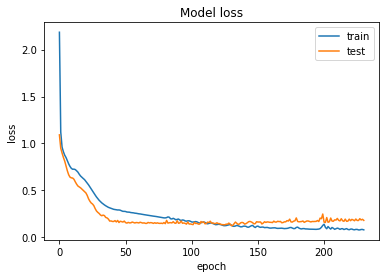

In [61]:
plt.plot(history_m['loss'])
plt.plot(history_m['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

plt.savefig('losses_downstream.png', dpi=300)

#money.summary()

In [59]:
# Test
Z = np.zeros((56,))
for i,meh in enumerate(X_test):
  testing = np.array(meh).reshape(1,X_train.shape[1])
  y = latent_model.predict(testing)
  z = money.predict(y)
  Z[i] = z


0.26670922111121137


0.8759744597716442

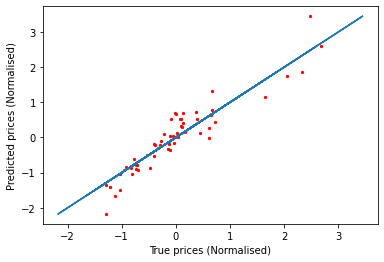

In [67]:
plt.scatter(Z, Y_test, color='r', s=5)
plt.plot(Y_test,Y_test)
plt.xlabel("True prices (Normalised)")
plt.ylabel("Predicted prices (Normalised)")

plt.savefig('predictions.png', dpi=300)

print(np.sqrt((Y_test - Z)**2).mean(axis=None))
r2_score(Y_test, Z)